# 2. Diffusion Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from IPython.display import Image

# User defined libraries
from utils import other_utils

IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 26421880/26421880 [00:01<00:00, 13601442.38it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 325340.22it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5986607.05it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11863888.46it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [2]:
nrows = 10
ncols = 15

T = nrows * ncols
start = 0.0001
end = 0.02
B = torch.linspace(start, end, T).to(device)
B

tensor([1.0000e-04, 2.3356e-04, 3.6711e-04, 5.0067e-04, 6.3423e-04, 7.6779e-04,
        9.0134e-04, 1.0349e-03, 1.1685e-03, 1.3020e-03, 1.4356e-03, 1.5691e-03,
        1.7027e-03, 1.8362e-03, 1.9698e-03, 2.1034e-03, 2.2369e-03, 2.3705e-03,
        2.5040e-03, 2.6376e-03, 2.7711e-03, 2.9047e-03, 3.0383e-03, 3.1718e-03,
        3.3054e-03, 3.4389e-03, 3.5725e-03, 3.7060e-03, 3.8396e-03, 3.9732e-03,
        4.1067e-03, 4.2403e-03, 4.3738e-03, 4.5074e-03, 4.6409e-03, 4.7745e-03,
        4.9081e-03, 5.0416e-03, 5.1752e-03, 5.3087e-03, 5.4423e-03, 5.5758e-03,
        5.7094e-03, 5.8430e-03, 5.9765e-03, 6.1101e-03, 6.2436e-03, 6.3772e-03,
        6.5107e-03, 6.6443e-03, 6.7779e-03, 6.9114e-03, 7.0450e-03, 7.1785e-03,
        7.3121e-03, 7.4456e-03, 7.5792e-03, 7.7128e-03, 7.8463e-03, 7.9799e-03,
        8.1134e-03, 8.2470e-03, 8.3805e-03, 8.5141e-03, 8.6477e-03, 8.7812e-03,
        8.9148e-03, 9.0483e-03, 9.1819e-03, 9.3154e-03, 9.4490e-03, 9.5826e-03,
        9.7161e-03, 9.8497e-03, 9.9832e-

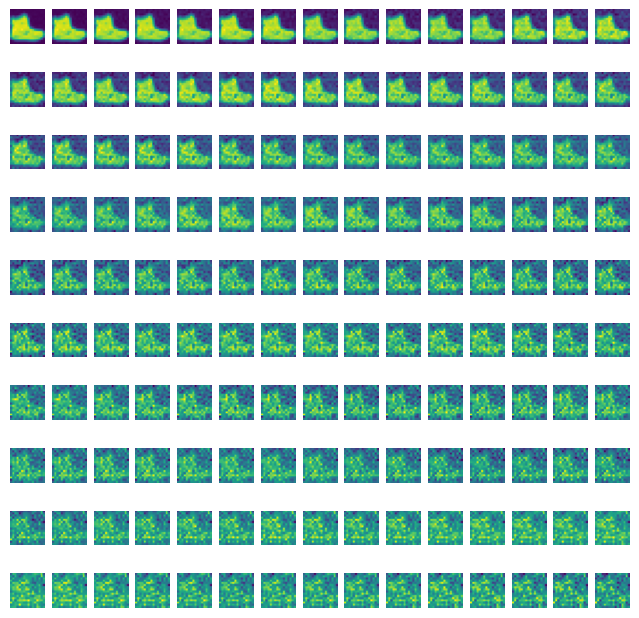

In [3]:
plt.figure(figsize=(8, 8))
x_0 = data[0][0].to(device)  # Initial image
x_t = x_0  # Set up recursion
xs = []  # Store x_t for each T to see change

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise  # sample from q(x_t|x_t-1)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis("off")
    plt.imshow(img)
plt.savefig("forward_diffusion.png", bbox_inches="tight")

MovieWriter ffmpeg unavailable; using Pillow instead.


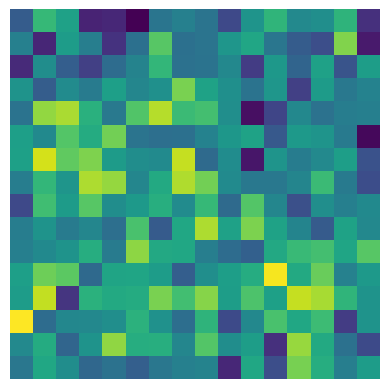

In [4]:
gif_name = "forward_diffusion.gif"
other_utils.save_animation(xs, gif_name)

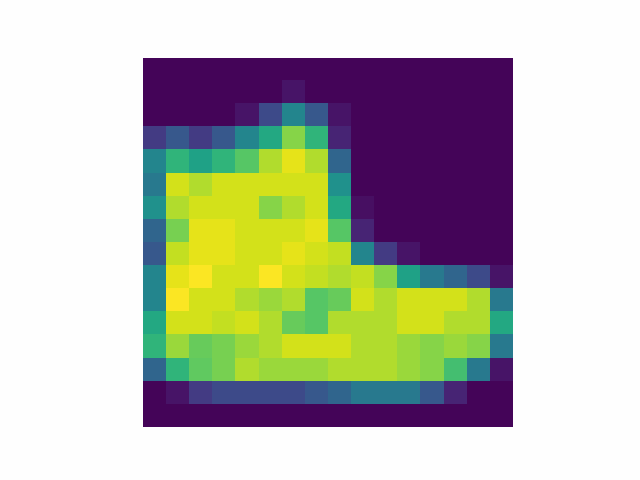

In [5]:
Image(open(gif_name,'rb').read())

In [6]:
a = 1. - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar) # St. Dev. Coefficient

In [7]:
def q(x_0, t):
  
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

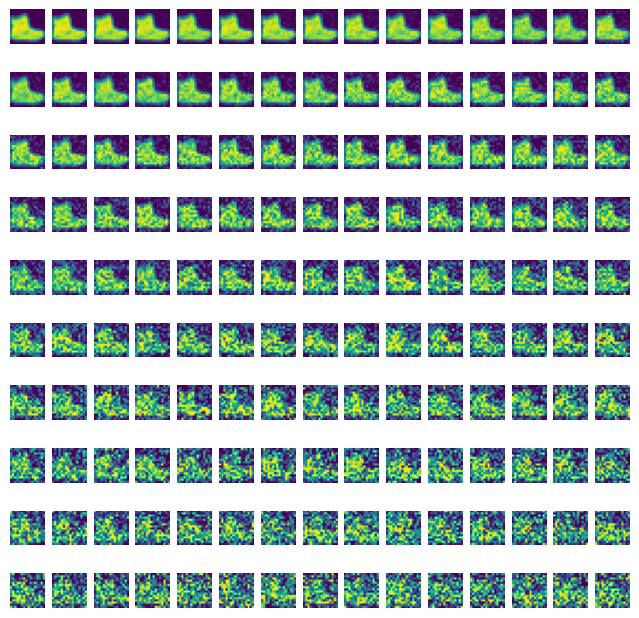

In [8]:
plt.figure(figsize=(8, 8))
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    other_utils.show_tensor_image(x_t)
plt.savefig("forward_diffusion_skip.png", bbox_inches='tight')

MovieWriter ffmpeg unavailable; using Pillow instead.


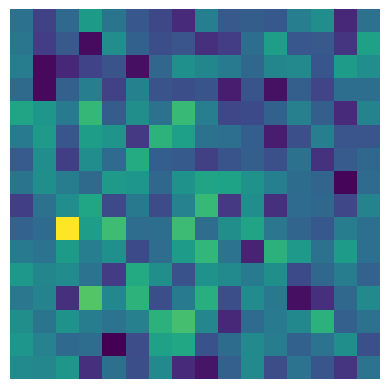

In [9]:
gif_name = "forward_diffusion_skip.gif"
other_utils.save_animation(xs, gif_name)

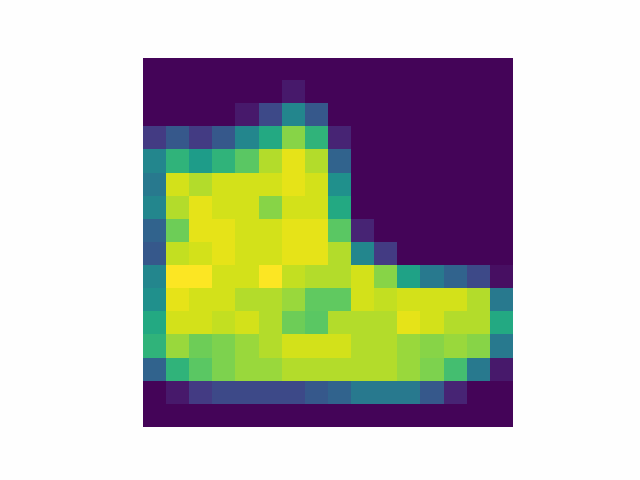

In [10]:
Image(open(gif_name,'rb').read())

In [19]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.input_dim)
        return self.model(input)

In [20]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
    nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding),
    nn.BatchNorm2d(out_chs),
    nn.ReLU(),
    nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding), 
    nn.BatchNorm2d(out_chs),
    nn.ReLU(),
    nn.MaxPool2d(2)


        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [21]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [22]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
    nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size, strideT, padding, out_paddingT),
    nn.BatchNorm2d(out_chs),
    nn.ReLU(),
    nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
    nn.BatchNorm2d(out_chs),
    nn.ReLU()
]

        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((FIXME, FIXME), 1)
        x = self.model(FIXME)
        return x

In [23]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [24]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0]) # New
        self.temb_2 = EmbedBlock(t_dim, up_chs[1]) # New
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

In [25]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])  # New
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])  # New
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        latent_vec = self.dense_emb(latent_vec)
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

In [26]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(UNet().to(device))

Num params:  240385


In [27]:
def get_loss(model, x_0, t):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

In [28]:
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)

In [29]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [30]:
@torch.no_grad()
def sample_images(ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = T / ncols

    # Noise to generate images from
    x_t = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            ax.axis('off')
            other_utils.show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

Epoch 0 | Step 000 | Loss: 1.3354406356811523 


/tmp/ipykernel_40/3817596156.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, ncols+1, plot_number)


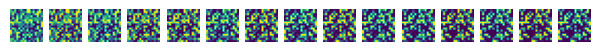

Epoch 0 | Step 100 | Loss: 0.4375966191291809 


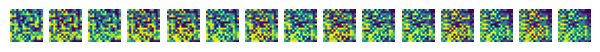

Epoch 0 | Step 200 | Loss: 0.2827143669128418 


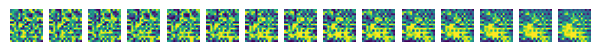

Epoch 0 | Step 300 | Loss: 0.24551700055599213 


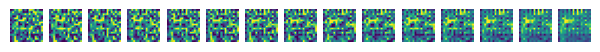

Epoch 0 | Step 400 | Loss: 0.22830232977867126 


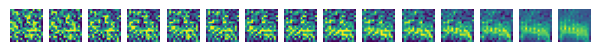

Epoch 0 | Step 500 | Loss: 0.2578411102294922 


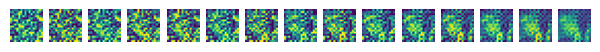

Epoch 1 | Step 000 | Loss: 0.19823089241981506 


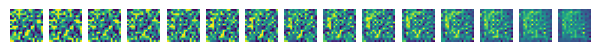

Epoch 1 | Step 100 | Loss: 0.18234239518642426 


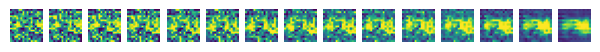

Epoch 1 | Step 200 | Loss: 0.19896429777145386 


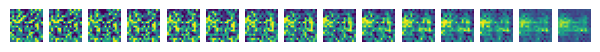

Epoch 1 | Step 300 | Loss: 0.1882530152797699 


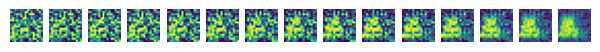

Epoch 1 | Step 400 | Loss: 0.18474116921424866 


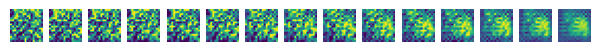

Epoch 1 | Step 500 | Loss: 0.17664742469787598 


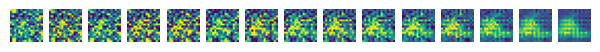

Epoch 2 | Step 000 | Loss: 0.16864410042762756 


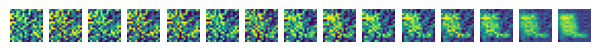

Epoch 2 | Step 100 | Loss: 0.17868396639823914 


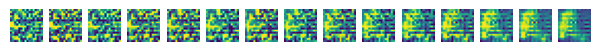

Epoch 2 | Step 200 | Loss: 0.17934191226959229 


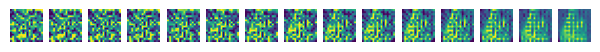

Epoch 2 | Step 300 | Loss: 0.1735219657421112 


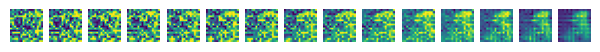

Epoch 2 | Step 400 | Loss: 0.17625513672828674 


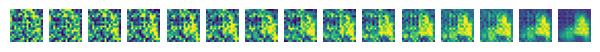

Epoch 2 | Step 500 | Loss: 0.20417766273021698 


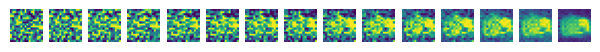

Final sample:


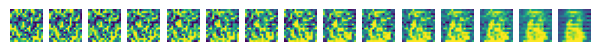

In [31]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
ncols = 15  # Should evenly divide T

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        x = batch[0].to(device)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
            sample_images(ncols)
print("Final sample:")
sample_images(ncols)

/tmp/ipykernel_40/3817596156.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, ncols+1, plot_number)


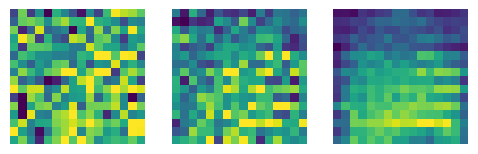

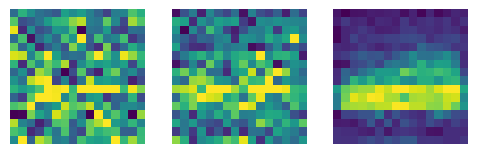

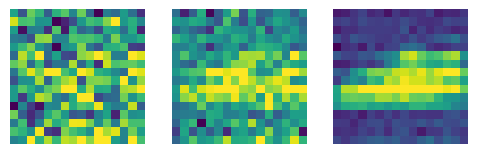

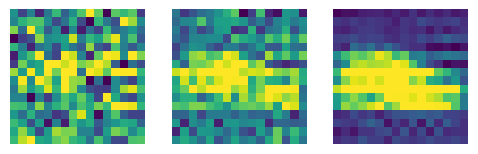

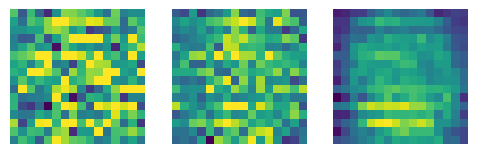

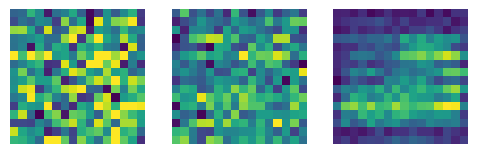

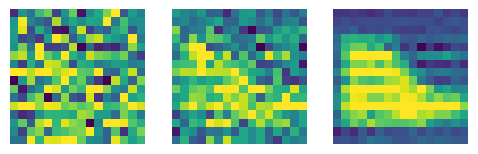

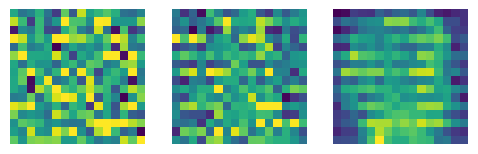

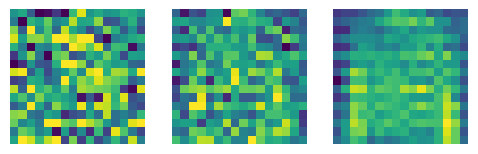

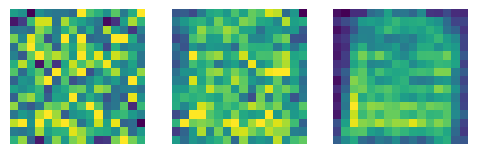

In [32]:
model.eval()
figsize=(8,8) # Change me
ncols = 3 # Should evenly divide T
for _ in range(10):
    sample_images(ncols, figsize=figsize)

In [33]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}